# Image Processing Functions

This notebook contains the functions for image processing that is used in the program and provides interactive cells ofr testing and understanding the working of the functions.

> Note: The library required for interactive cells is `ipywidgets` which is not included in the `requirements.txt` file as it is not part of the main program. You can install it using `pip install ipywidgets` or `pip3 install ipywidgets` if you are using a virtual environment.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution
from scipy.stats import cauchy, logistic
from PIL import Image, ImageEnhance
from ipywidgets import interact

In [2]:
def show_img(img):
    plt.imshow(img)
    plt.show()

## Combining the grey-scale images into the color image
Takes the 3 grey-scale images of different channels and combines them into a color image.

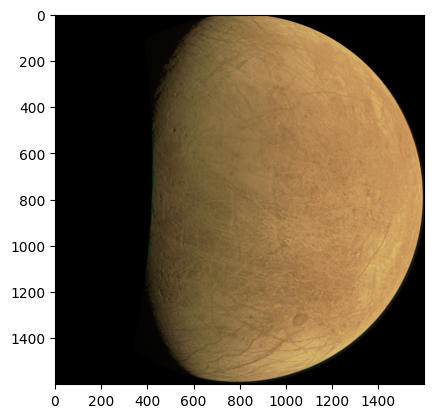

In [4]:
GREEN_IMG = 'ImageSet/JNCE_2022272_45C00002_V01-green.png'
BLUE_IMG = 'ImageSet/JNCE_2022272_45C00002_V01-blue.png'
RED_IMG = 'ImageSet/JNCE_2022272_45C00002_V01-red.png'

imageBlue = cv2.imread(BLUE_IMG, 0)
imageGreen = cv2.imread(GREEN_IMG, 0)
imageRed = cv2.imread(RED_IMG, 0)

rgb = np.zeros((imageBlue.shape[0], imageBlue.shape[1], 3), dtype=np.uint8)
rgb[:, :, 0] = imageRed[:, :]
rgb[:, :, 1] = imageGreen[:, :]
rgb[:, :, 2] = imageBlue[:, :]

show_img(rgb)

## Channel Correction
Multiplies the values in the given channel with a constant value. This is useful for correcting the brightness of a specific channel of an image.

In [3]:
def channel_correction(img, channel, correction):
    img[:, :, channel] = img[:, :, channel] * correction
    return img

In [5]:
@interact(red=(0,100), green=(0,100), blue=(0,100))
def correct(red=100, green=100, blue=100):
    corrected = channel_correction(rgb.copy(), (0,1,2), (red / 100, green / 100, blue / 100))
    show_img(corrected)

interactive(children=(IntSlider(value=100, description='red'), IntSlider(value=100, description='green'), IntS…

## Applying linear distribution to the channels of the Image
Applies linear distribution to the channels of the image. This is useful for getting better color balance in the image.

In [6]:
def show_linear_cdf(image, channel, name, ax):
    image_intensity = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    ax.step(bins, freq, c='b', label='Actual CDF')
    ax.plot(target_bins, target_freq, c='r', label='Target CDF')
    ax.legend()
    ax.set_title('{} Channel: Actual vs. '
                 'Target Cumulative Distribution'.format(name))
                 
def linear_distribution(image, channel):
    image_intensity = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    new_vals = np.interp(freq, target_freq, target_bins)
    return new_vals[image_intensity].astype(np.uint8)

Text(0.5, 1.0, 'Corrected Image in Blue Channel')

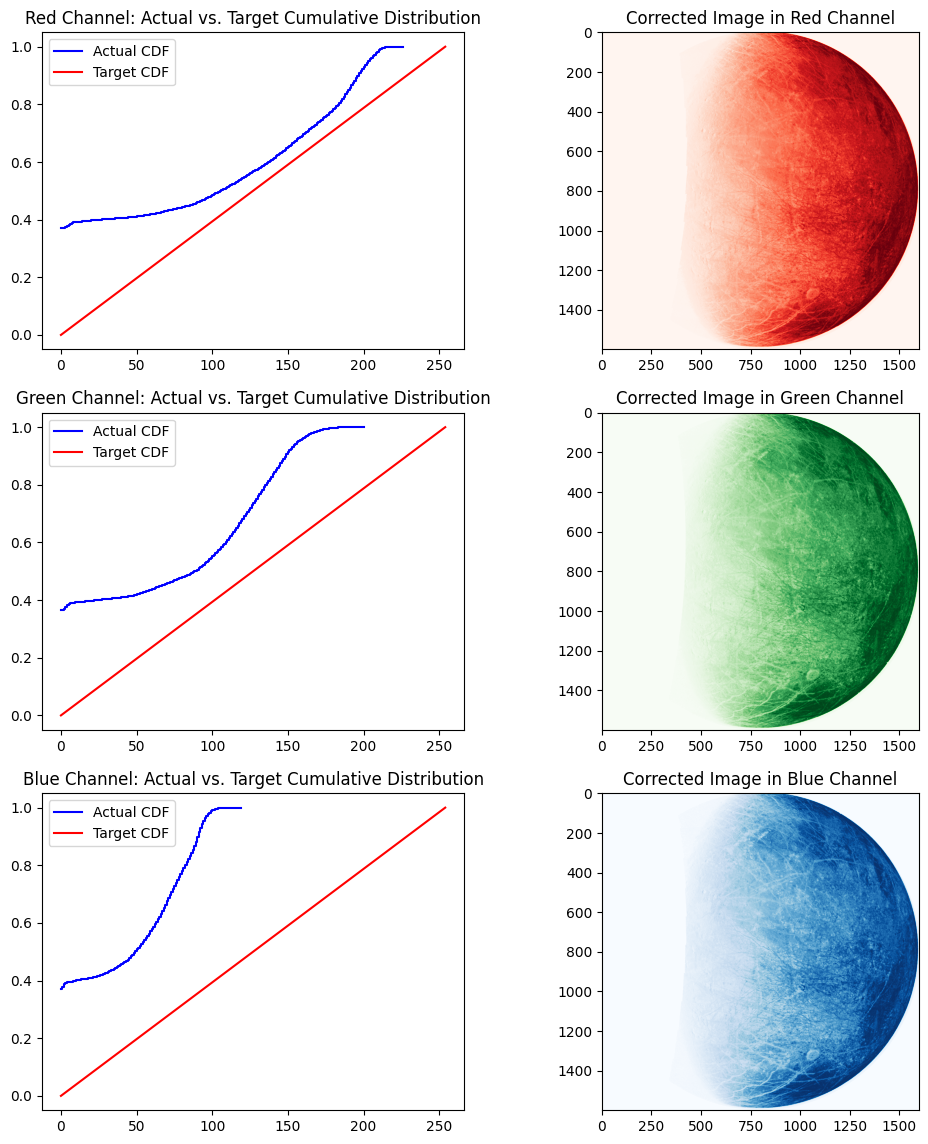

In [7]:
fig, ax = plt.subplots(3,2, figsize=(12,14))
red_channel = linear_distribution(rgb, 0)
green_channel = linear_distribution(rgb, 1)
blue_channel = linear_distribution(rgb, 2)
show_linear_cdf(rgb, 0, 'Red', ax[0,0])
ax[0,1].imshow(red_channel, cmap='Reds')
ax[0,1].set_title('Corrected Image in Red Channel')
show_linear_cdf(rgb, 1, 'Green', ax[1,0])
ax[1,1].imshow(green_channel, cmap='Greens')
ax[1,1].set_title('Corrected Image in Green Channel')
show_linear_cdf(rgb, 2, 'Blue', ax[2,0])
ax[2,1].imshow(blue_channel, cmap='Blues')
ax[2,1].set_title('Corrected Image in Blue Channel')

Text(0.5, 1.0, 'Transformed Image')

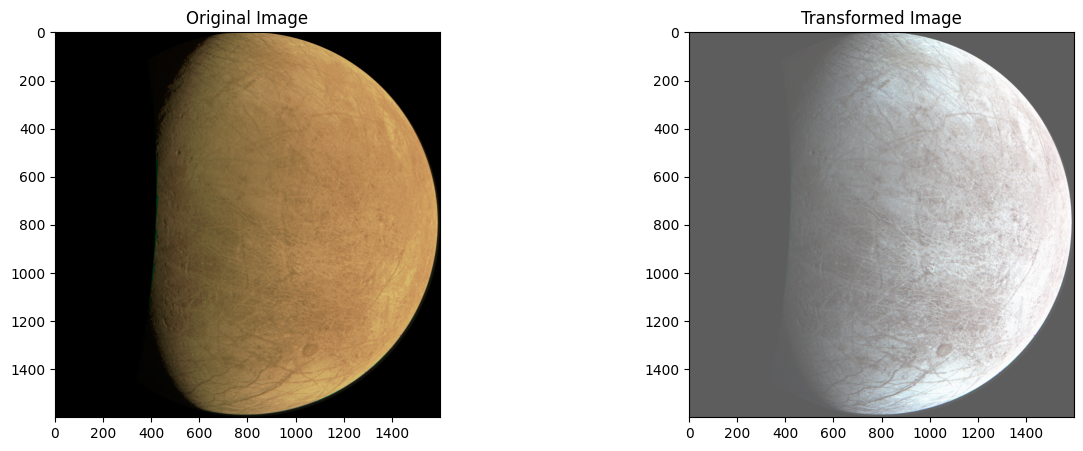

In [8]:
rgb2 = np.dstack([red_channel, green_channel, blue_channel])
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(rgb)
ax[0].set_title('Original Image')
ax[1].imshow(rgb2)
ax[1].set_title('Transformed Image')

## Changing the Brightness, Contrast and Sharpness of the Image

In [22]:
rgb3 = rgb2
@interact(sharpness=(0,10), contrast=(0,10), brightness=(0,500))
def enhance(sharpness=1, contrast=1, brightness=100):
    rgb3 = ImageEnhance.Brightness(Image.fromarray(rgb2.copy())).enhance(brightness/ 100)
    rgb3 = ImageEnhance.Contrast(rgb3).enhance(contrast)
    rgb3 = ImageEnhance.Sharpness(rgb3).enhance(sharpness)
    plt.imshow(rgb3)

interactive(children=(IntSlider(value=1, description='sharpness', max=10), IntSlider(value=1, description='con…

## Code for Manually Applying curve balancing to the Image

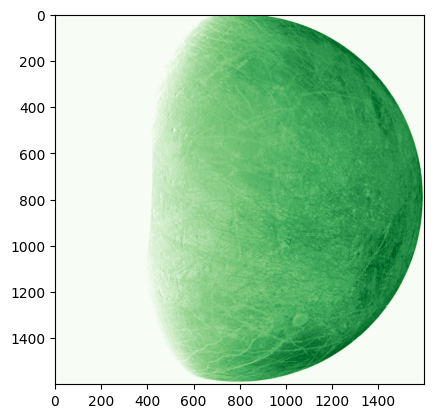

In [28]:
ranges = np.arange(20, 255, 32)
curve_values = np.arange(0, 255, 32)
lut = np.zeros(256, dtype = 'uint8')
for i in range(len(ranges) - 1):
    lut[ranges[i]:ranges[i+1]] = np.linspace(curve_values[i], curve_values[i+1], ranges[i+1] - ranges[i], dtype = 'uint8')
rgb4 = cv2.LUT(rgb[:,:,1], lut)
plt.imshow(rgb4, cmap='Greens') 


In [25]:
rgb4 = np.array(rgb3)
rgb5 = np.array(rgb3)
@interact(r1=(0,255), r2=(0,255), r3=(0,255), r4=(0,255), r5=(0,255), r6=(0,255), r7=(0,255), r8=(0,255))
def color_curve_red(r1 = 20, r2 = 52, r3 = 84, r4 = 116, r5 = 148, r6 = 180, r7 = 212, r8 = 244):
    ranges = np.arange(20, 255, 32)
    curve_values = np.array([r1, r2, r3, r4, r5, r6, r7, r8])
    lut = np.zeros(256, dtype = 'uint8')
    for i in range(len(ranges) - 1):
        lut[ranges[i]:ranges[i+1]] = np.linspace(curve_values[i], curve_values[i+1], ranges[i+1] - ranges[i], dtype = 'uint8')
        
    lut[ranges[-1]:] = curve_values[-1]
    r_channel = rgb4[:,:,0]
    r_channel = cv2.LUT(r_channel, lut)
    rgb5[:,:,0] = r_channel
    plt.subplot(1,2,1)
    plt.imshow(r_channel, cmap='Reds')
    plt.subplot(1,2,2)
    plt.imshow(rgb5)

interactive(children=(IntSlider(value=20, description='r1', max=255), IntSlider(value=52, description='r2', ma…

In [14]:

@interact(g1=(0,255), g2=(0,255), g3=(0,255), g4=(0,255), g5=(0,255), g6=(0,255), g7=(0,255), g8=(0,255))
def color_curve_green(g1 = 20, g2 = 52, g3 = 84, g4 = 116, g5 = 148, g6 = 180, g7 = 212, g8 = 244):
    ranges = np.arange(20, 255, 32)
    curve_values = np.array([g1, g2, g3, g4, g5, g6, g7, g8])
    lut = np.zeros(256, dtype = 'uint8')
    for i in range(len(ranges) - 1):
        lut[ranges[i]:ranges[i+1]] = np.linspace(curve_values[i], curve_values[i+1], ranges[i+1] - ranges[i], dtype = 'uint8')
    lut[ranges[-1]:] = curve_values[-1]
    g_channel = rgb4[:,:,1]
    g_channel = cv2.LUT(g_channel, lut)
    rgb5[:,:,1] = g_channel
    plt.subplot(1,2,1)
    plt.imshow(g_channel, cmap='Greens')
    plt.subplot(1,2,2)
    plt.imshow(rgb5)

interactive(children=(IntSlider(value=20, description='g1', max=255), IntSlider(value=52, description='g2', ma…

In [26]:

@interact(b1=(0,255), b2=(0,255), b3=(0,255), b4=(0,255), b5=(0,255), b6=(0,255), b7=(0,255), b8=(0,255))
def color_curve_blue(b1 = 20, b2 = 52, b3 = 84, b4 = 116, b5 = 148, b6 = 180, b7 = 212, b8 = 244):
    ranges = np.arange(20, 255, 32)
    curve_values = np.array([b1, b2, b3, b4, b5, b6, b7, b8])
    lut = np.zeros(256, dtype = 'uint8')
    for i in range(len(ranges) - 1):
        lut[ranges[i]:ranges[i+1]] = np.linspace(curve_values[i], curve_values[i+1], ranges[i+1] - ranges[i], dtype = 'uint8')
    lut[ranges[-1]:] = curve_values[-1]
    b_channel = rgb4[:,:,2]
    b_channel = cv2.LUT(b_channel, lut)
    rgb5[:,:,2] = b_channel
    plt.subplot(1,2,1)
    plt.imshow(b_channel, cmap='Blues')
    plt.subplot(1,2,2)
    plt.imshow(rgb5)

interactive(children=(IntSlider(value=20, description='b1', max=255), IntSlider(value=52, description='b2', ma…

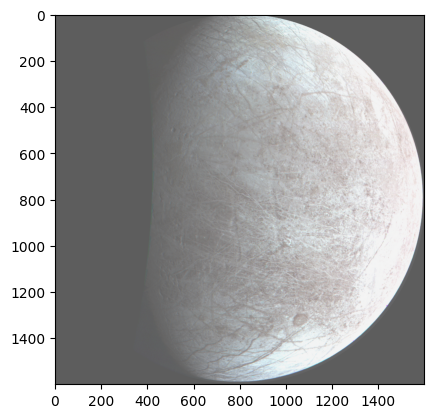

In [16]:
plt.imshow(rgb5)